# Sales Forecasting using Temporal F Transformer

In [1]:
import pandas as pd

# Load the dataset
file_path = "./sales_data.csv"
df = pd.read_csv(file_path)

# Display basic info and first few rows
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distributor_id        10000 non-null  object 
 1   industry              10000 non-null  object 
 2   sku                   10000 non-null  object 
 3   category              10000 non-null  object 
 4   sales                 10000 non-null  float64
 5   avg_quarterly_sales   10000 non-null  float64
 6   movement_category     10000 non-null  object 
 7   quarter               10000 non-null  int64  
 8   year                  10000 non-null  int64  
 9   total_quarter_sales   10000 non-null  float64
 10  prev_quarter_sales    10000 non-null  float64
 11  is_diwali             10000 non-null  int64  
 12  is_ganesh_chaturthi   10000 non-null  int64  
 13  is_gudi_padwa         10000 non-null  int64  
 14  is_eid                10000 non-null  int64  
 15  is_akshay_tritiya   

(None,
   distributor_id       industry                            sku    category  \
 0        DIST036     Healthcare               MDH Garam Masala        Food   
 1        DIST007     E-commerce           Shell Helix Ultra 4L  Automotive   
 2        DIST012         Retail  PlayStation 5 Digital Edition        Toys   
 3        DIST034     E-commerce  PlayStation 5 Digital Edition        Toys   
 4        DIST009  Manufacturing     Britannia Good Day Cookies        Food   
 
       sales  avg_quarterly_sales movement_category  quarter  year  \
 0   4726.09              6345.93       Fast Moving        2  2022   
 1   4015.00              4141.90       Slow Moving        3  2023   
 2  12386.14             13593.10            Medium        2  2024   
 3  13198.10             13593.10            Medium        4  2020   
 4   3148.80              4600.58            Medium        1  2023   
 
    total_quarter_sales  prev_quarter_sales  is_diwali  is_ganesh_chaturthi  \
 0              

In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encode categorical variables
categorical_cols = ["distributor_id", "industry", "sku", "category", "movement_category"]
encoders = {col: LabelEncoder() for col in categorical_cols}

for col in categorical_cols:
    df[col] = encoders[col].fit_transform(df[col])

# Scale numerical features
scaler = StandardScaler()
numerical_cols = ["avg_quarterly_sales", "total_quarter_sales", "prev_quarter_sales"]
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Ensure time index is sorted correctly
df = df.sort_values(by=["time_idx"]).reset_index(drop=True)

# Check the processed dataset
df.head()


,distributor_id,industry,sku,category,sales,avg_quarterly_sales,movement_category,quarter,year,total_quarter_sales,prev_quarter_sales,is_diwali,is_ganesh_chaturthi,is_gudi_padwa,is_eid,is_akshay_tritiya,is_dussehra_navratri,is_onam,is_christmas,time_idx
0,0,5,136,10,2938.93,-0.541321,1,2,2021,-0.422724,-0.439632,0,0,1,1,1,0,0,0,6
1,0,5,136,10,4818.94,-0.541321,1,4,2022,-0.235458,-0.249025,1,0,0,0,0,1,0,1,12
2,0,5,136,10,3712.86,-0.541321,1,2,2023,-0.345633,-0.213901,0,0,1,0,1,0,0,0,13
3,0,5,136,10,3487.30,-0.541321,1,3,2024,-0.368101,-0.386054,0,1,0,0,0,1,1,0,18
4,0,5,136,10,2768.32,-0.541321,0,1,2025,-0.439718,-0.159757,0,0,1,1,0,0,0,0,20


In [ ]:
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import NaNLabelEncoder
# import torch

# Define parameters
max_prediction_length = 4  # Forecasting 4 quarters ahead
max_encoder_length = 7  # Using 8 past quarters as input

# Define dataset
training_cutoff = df["time_idx"].max() - max_prediction_length

# Define known real variables (including one-hot encoded festival indicators)
time_varying_known_reals = [
    "quarter", "year",  # Known future values
    "is_diwali", "is_ganesh_chaturthi", "is_gudi_padwa", 
    "is_eid", "is_akshay_tritiya", "is_dussehra_navratri", 
    "is_onam", "is_christmas"  # One-hot encoded variables
]

tft_dataset = TimeSeriesDataSet(
    df,
    allow_missing_timesteps=True,
    time_idx="time_idx",
    target="sales",
    group_ids=["sku"],  # Group by SKU for forecasting per product
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=time_varying_known_reals,  # Festival indicators as real values
    time_varying_unknown_reals=["sales", "avg_quarterly_sales", "total_quarter_sales", "prev_quarter_sales", "movement_category"],
    # ✅ FIX: Use NaNLabelEncoder instead of sklearn's LabelEncoder
    categorical_encoders={"movement_category": NaNLabelEncoder(add_nan=True)},
    target_normalizer=None,  # No normalization for sales
)


# Split dataset into training and validation sets
train_dataloader = tft_dataset.to_dataloader(train=True, batch_size=32, num_workers=3)

val_dataloader = tft_dataset.to_dataloader(train=False, batch_size=32, num_workers=3)


train_batch = next(iter(train_dataloader))

In [16]:

from lightning import Trainer
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss

# Define the TFT model
tft = TemporalFusionTransformer.from_dataset(
    tft_dataset,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    loss=QuantileLoss(),
    output_size=7,  # 7 quantiles for prediction
    optimizer="adam",
)

trainer = Trainer(
    max_epochs=30,
    accelerator="cpu",  # Change to "gpu" if you have CUDA
    gradient_clip_val=0.1
)

# Train the model properly
trainer.fit(
    model=tft, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=val_dataloader
)

/home/home/Coding-practice/Projects/Personal/INC_Sales_Forecasting_Project/venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/home/Coding-practice/Projects/Personal/INC_Sales_Forecasting_Project/venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss             

Epoch 29: 100%|██████████| 57/57 [01:05<00:00,  0.87it/s, v_num=2, train_loss_step=1.25e+3, val_loss=2.38e+3, train_loss_epoch=2.4e+3] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 57/57 [01:06<00:00,  0.86it/s, v_num=2, train_loss_step=1.25e+3, val_loss=2.38e+3, train_loss_epoch=2.4e+3]


In [17]:
best_model_path = trainer.checkpoint_callback.best_model_path
tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)


In [18]:
# Select data for prediction (future time steps)
future_data = df[df["time_idx"] > df["time_idx"].max() - max_prediction_length]


In [19]:
print(future_data["time_idx"].min(), future_data["time_idx"].max())
print("Expected Future Time Indices:", df["time_idx"].max() + 1, "to", df["time_idx"].max() + max_prediction_length)

37966 37966
Expected Future Time Indices: 37967 to 37967


In [20]:
# Define the number of future time steps
last_time_idx = df["time_idx"].max()
future_time_idx = list(range(last_time_idx + 1, last_time_idx + max_prediction_length + 1))

# Create future data by repeating for each SKU
future_data_list = []
for sku in df["sku"].unique():
    last_row = df[(df["sku"] == sku) & (df["time_idx"] == last_time_idx)].copy()
    if not last_row.empty:
        for idx in future_time_idx:
            new_row = last_row.copy()
            new_row["time_idx"] = idx
            new_row["sales"] = None  # Set target variable to NaN
            future_data_list.append(new_row)

# Concatenate all future rows into a DataFrame
future_data = pd.concat(future_data_list, ignore_index=True)

In [21]:
predictions = tft.predict(future_data, stop_randomization=True)


/home/home/Coding-practice/Projects/Personal/INC_Sales_Forecasting_Project/venv/lib/python3.12/site-packages/pytorch_forecasting/data/timeseries.py:1831: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 1 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__sku': 96}]
  warnings.warn(


AssertionError: filters should not remove entries all entries - check encoder/decoder lengths and lags

In [22]:
print(future_data.head())  # Check the first few rows
print(future_data.groupby("sku")["time_idx"].nunique())  # Ensure each SKU has unique time indices
print(f"Expected Future Time Indices: {last_time_idx + 1} to {last_time_idx + max_prediction_length}")


   distributor_id  industry  sku  category sales  avg_quarterly_sales  \
0              49         7   96         4  None             1.024784   

   movement_category  quarter  year  total_quarter_sales  prev_quarter_sales  \
0                  1        1  2023             0.584898            2.825884   

   is_diwali  is_ganesh_chaturthi  is_gudi_padwa  is_eid  is_akshay_tritiya  \
0          0                    0              1       1                  0   

   is_dussehra_navratri  is_onam  is_christmas  time_idx  
0                     0        0             0     37967  
sku
96    1
Name: time_idx, dtype: int64
Expected Future Time Indices: 37967 to 37967


In [17]:

# Convert it into a TimeSeriesDataSet
prediction_dataset = TimeSeriesDataSet.from_dataset(
    tft_dataset, future_data, predict=True, stop_randomization=True
)

# Create DataLoader for prediction
prediction_dataloader = prediction_dataset.to_dataloader(batch_size=64, num_workers=0)


ValueError: ((4,), (1,))

In [ ]:
# # Get predictions
# raw_predictions, x = tft.predict(prediction_dataloader, return_x=True)

# Convert predictions to a DataFrame
import pandas as pd
predicted_sales = pd.DataFrame(predictions.numpy(), columns=["q0.1", "q0.5", "q0.9"])  # Example for 10th, 50th, and 90th quantile

print(predicted_sales.head())  # Check predictions


NameError: name 'prediction_dataloader' is not defined

In [ ]:
tft.plot_prediction(x, predictions, idx=0)  # Change idx for different series


NameError: name 'x' is not defined

In [ ]:
metrics_df = pd.read_csv("./lightning_logs/version_0/metrics.csv")

In [ ]:
metrics_df.head()

,epoch,step,train_loss_epoch,train_loss_step,val_MAE,val_MAPE,val_RMSE,val_SMAPE,val_loss
0,0,20,NaN,NaN,7213.382324,0.991546,10644.675781,1.966814,7212.796875
1,0,20,7226.354004,NaN,NaN,NaN,NaN,NaN,NaN
2,1,41,NaN,NaN,7163.646484,0.972060,10609.186523,1.894672,7162.566406
3,1,41,7191.297852,NaN,NaN,NaN,NaN,NaN,NaN
4,2,49,NaN,6244.689453,NaN,NaN,NaN,NaN,NaN


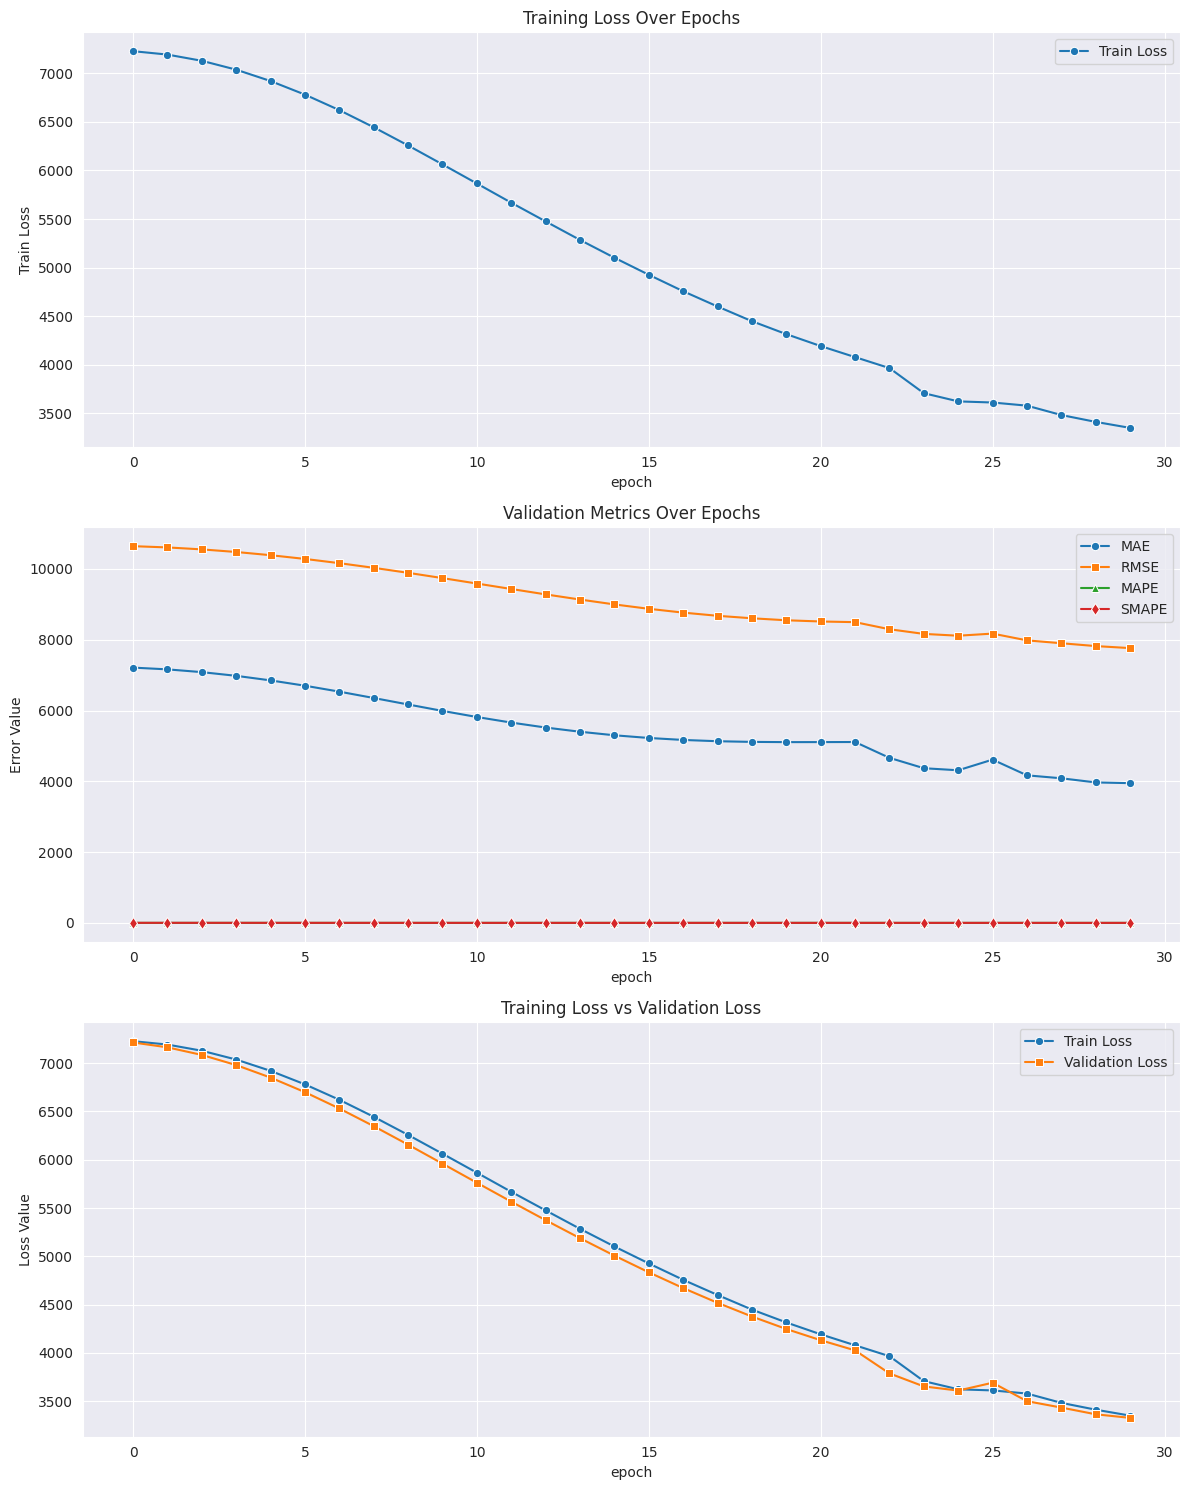

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set_style("darkgrid")

# Filter out NaN values for plotting
train_loss_df = metrics_df.dropna(subset=["train_loss_epoch"])
val_metrics_df = metrics_df.dropna(subset=["val_MAE", "val_RMSE", "val_MAPE", "val_SMAPE", "val_loss"])

# Create a figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# 1️⃣ Training Loss Over Epochs
sns.lineplot(data=train_loss_df, x="epoch", y="train_loss_epoch", ax=axes[0], marker="o", label="Train Loss")
axes[0].set_title("Training Loss Over Epochs")
axes[0].set_ylabel("Train Loss")

# 2️⃣ Validation Metrics Over Epochs
sns.lineplot(data=val_metrics_df, x="epoch", y="val_MAE", ax=axes[1], marker="o", label="MAE")
sns.lineplot(data=val_metrics_df, x="epoch", y="val_RMSE", ax=axes[1], marker="s", label="RMSE")
sns.lineplot(data=val_metrics_df, x="epoch", y="val_MAPE", ax=axes[1], marker="^", label="MAPE")
sns.lineplot(data=val_metrics_df, x="epoch", y="val_SMAPE", ax=axes[1], marker="d", label="SMAPE")
axes[1].set_title("Validation Metrics Over Epochs")
axes[1].set_ylabel("Error Value")
axes[1].legend()

# 3️⃣ Training vs Validation Loss
sns.lineplot(data=train_loss_df, x="epoch", y="train_loss_epoch", ax=axes[2], marker="o", label="Train Loss")
sns.lineplot(data=val_metrics_df, x="epoch", y="val_loss", ax=axes[2], marker="s", label="Validation Loss")
axes[2].set_title("Training Loss vs Validation Loss")
axes[2].set_ylabel("Loss Value")
axes[2].legend()

# Show plots
plt.tight_layout()
plt.show()
